## Modeling - All Crimes

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Read in Data

In [2]:
crimes_byday = pd.read_csv('../data/crimes_byday.csv', index_col = 0, parse_dates = True)

In [3]:
crimes_byday['Total Crimes'].sum()

7255968

In [4]:
crimes_byday.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7301 entries, 2001-01-01 to 2020-12-27
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Total Crimes         7301 non-null   int64
 1   Arrest               7301 non-null   int64
 2   Domestic             7301 non-null   int64
 3   Violent              7301 non-null   int64
 4   Property             7301 non-null   int64
 5   Public Order / Vice  7301 non-null   int64
 6   Drugs                7301 non-null   int64
 7   White Collar         7301 non-null   int64
 8   Other                7301 non-null   int64
dtypes: int64(9)
memory usage: 570.4 KB


In [5]:
crimes_byday.index.freq='D'

## Holt-Winters Model

We'll split the data into 19 years of training data and 1 year of test data.

In [6]:
train = crimes_byday['Total Crimes'].loc['2001-01-01':'2020-01-01']
test = crimes_byday['Total Crimes'].loc['2020-01-01':]

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
HW_model = ExponentialSmoothing(train,trend='add',seasonal='add',seasonal_periods=365).fit()

In [9]:
start=len(train)
end=len(train)+len(test)-1
HW_preds = HW_model.predict(start=start, end=end).rename('HW Predictions')

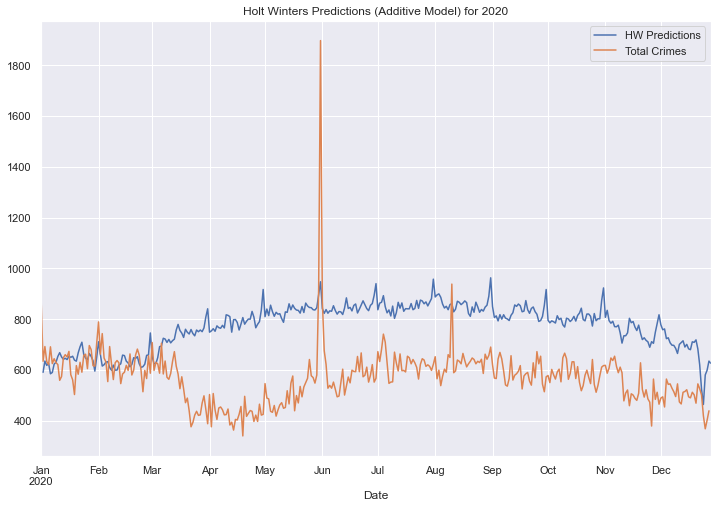

In [10]:
HW_preds.plot(figsize=(12,8),legend=True)
test.plot(legend=True);
plt.title('Holt Winters Predictions (Additive Model) for 2020');

The model predicts the data quite well for 2020 until early March, which is when the shut-downs for the pandemic started. Then throughout the remainder for 2020 crime must have been down due to the pandemic and social distancing (restaurants and stores being closed), aside from the peak in June and August during the violent protests.  

In [11]:
mae = mean_absolute_error(test, HW_preds)
print(f'MAE Error: {mae:11.10}')
rmse = np.sqrt(mean_squared_error(test, HW_preds))
print(f'RMSE Error: {rmse:11.10}')

MAE Error: 217.8056131
RMSE Error: 247.0102259


In [13]:
crimes_byday['Total Crimes'].describe()

count    7301.000000
mean      993.832078
std       274.736279
min       320.000000
25%       761.000000
50%       973.000000
75%      1235.000000
max      2027.000000
Name: Total Crimes, dtype: float64

So the MAE and RMSE are slightly less than the standard error, which isn't great but not unexpected due to the impact of the pandemic.  You can also see that the model is not capturing the shock to the system on June 1st (we wouldn't expect it to).  

Let's try to fit a multiplicative model.

In [14]:
HW_model = ExponentialSmoothing(train,trend='mul',seasonal='mul',seasonal_periods=365).fit()

In [15]:
start=len(train)
end=len(train)+len(test)-1
HW_preds = HW_model.predict(start=start, end=end).rename('HW Predictions')

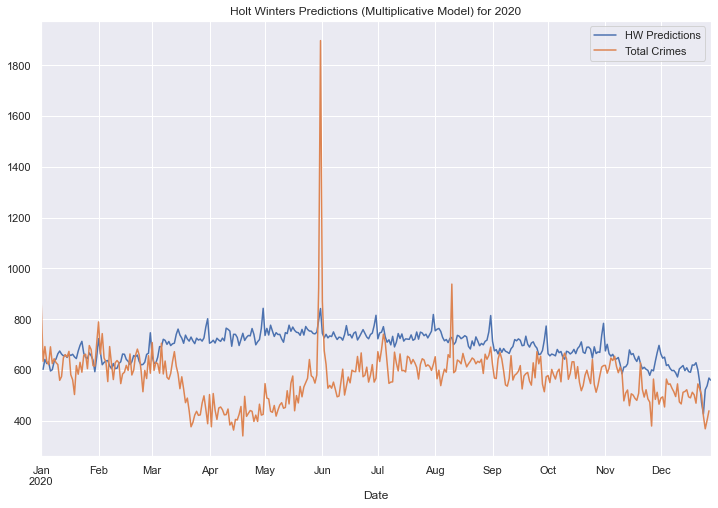

In [16]:
HW_preds.plot(figsize=(12,8),legend=True)
test.plot(legend=True);
plt.title('Holt Winters Predictions (Multiplicative Model) for 2020');

In [17]:
mae = mean_absolute_error(test, HW_preds)
print(f'MAE Error: {mae:11.10}')
rmse = np.sqrt(mean_squared_error(test, HW_preds))
print(f'RMSE Error: {rmse:11.10}')

MAE Error: 137.4954644
RMSE Error: 173.7834858


So we can see that this model performed much better, even though it also diverged from the actual data when the pandemic began.  

How did the multiplicative model do for 2019?

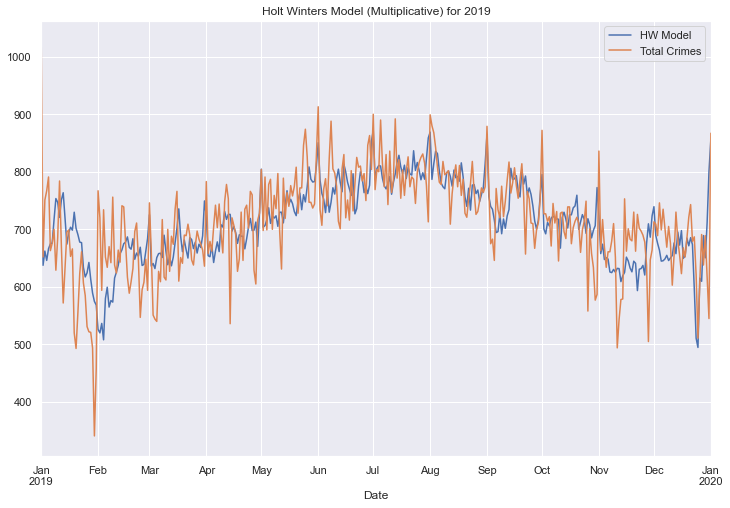

In [18]:
HW_model.fittedvalues.loc['2019-01-01':'2020-01-01'].rename('HW Model').plot(figsize=(12,8), legend=True)
train.loc['2019-01-01':'2020-01-01'].plot(legend=True)
plt.title('Holt Winters Model (Multiplicative) for 2019');

This looks quite good.  Now we can fit the model on all of the data and predict crimes for 2021.  

In [19]:
HW_model = ExponentialSmoothing(crimes_byday['Total Crimes'],trend='mul',seasonal='mul',seasonal_periods=365).fit()

In [20]:
start=len(crimes_byday['Total Crimes'])
end=len(crimes_byday['Total Crimes']) + 365
HW_preds = HW_model.predict(start=start, end=end).rename('HW Predictions for 2021')

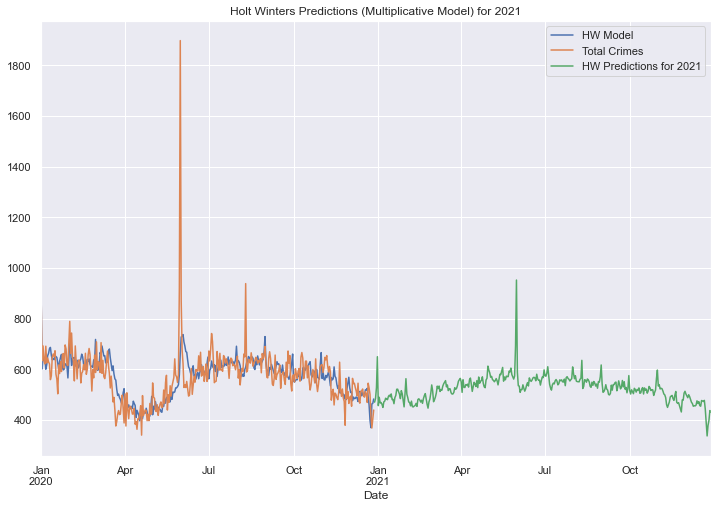

In [21]:
HW_model.fittedvalues.loc['2020-01-01':'2021-01-01'].rename('HW Model').plot(figsize=(12,8), legend=True)
crimes_byday['Total Crimes'].loc['2020-01-01':'2021-01-01'].plot(legend=True)
HW_preds.plot(legend=True)
plt.title('Holt Winters Predictions (Multiplicative Model) for 2021');

Our model, once fitted on all the data, follows the pattern quite well for 2020 and then predicts into 2021. Notice that while it doesn't quite capture the violent riots in June of 2020, it does predict another riot next summer! 

### SARIMA Model

In [ ]:
# THIS IS TIMING OUT

#Get best parameters from auto_arima

# stepwise_fit = auto_arima(allcrimes_byday['Total Crimes'], 
#                           m=365,
#                           seasonal=True,
#                           trace=True,
#                           error_action='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings=True,  # we don't want convergence warnings
#                           stepwise=True)           # set to stepwise

# stepwise_fit.summary()